In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import xgboost as xgb

from sklearn.datasets import make_multilabel_classification, make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report, f1_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier

from sklearn.utils.validation import _check_fit_params
from sklearn.base import is_classifier
from sklearn.utils.fixes import delayed
from joblib import Parallel
from sklearn.multioutput import _fit_estimator, check_classification_targets

from sklearn.model_selection import GridSearchCV
from hyperopt.pyll.base import scope 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# import talos as ta

# Machine learning
## TPE search single output regression

In [22]:
def plot_cm_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
#     plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.show()

def format_params(space, best):
    best['objective'] = obj.get(best['objective'])
    best['max_depth'] += 1
    best['min_child_weight'] += 1
    for k,v in space.items():
        if k not in best.keys():
            best[k] = v
    return best

class CustomMultiOutputRegressor(MultiOutputRegressor):
    def fit(self, X, y, sample_weight=None, **fit_params):
        if not hasattr(self.estimator, "fit"):
            raise ValueError("The base estimator should implement a fit method")
        X, y = self._validate_data(X, y, force_all_finite=False, multi_output=True, accept_sparse=True)
        if is_classifier(self):
            check_classification_targets(y)
        if y.ndim == 1:
            raise ValueError("y must have at least two dimensions for multi-output regression but has only one.")
        if (sample_weight is not None and not has_fit_parameter(self.estimator, 'sample_weight')):
            raise ValueError("Underlying estimator does not support sample weights.")
        
        fit_params_validated = _check_fit_params(X, fit_params)
        [(X_train, Y_train), (X_test, Y_test)] = fit_params_validated.pop('eval_set')
        
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_estimator)(self.estimator,
                                                                                X,
                                                                                y[:, i],
                                                                                sample_weight,
                                                                                **fit_params_validated,
                                                                                eval_set=[(X_train, Y_train[:, i]),
                                                                                          (X_test, Y_test[:, i])])
                                                        for i in range(y.shape[1]))
        return self
    
class CustomMultiOutputClassifier(MultiOutputClassifier):
    def fit(self, X, y, sample_weight=None, **fit_params):
        if not hasattr(self.estimator, "fit"):
            raise ValueError("The base estimator should implement a fit method")
        X, y = self._validate_data(X, y, force_all_finite=False, multi_output=True, accept_sparse=True)
        if is_classifier(self):
            check_classification_targets(y)
        if y.ndim == 1:
            raise ValueError("y must have at least two dimensions for multi-output regression but has only one.")
        if (sample_weight is not None and not has_fit_parameter(self.estimator, 'sample_weight')):
            raise ValueError("Underlying estimator does not support sample weights.")
        
        fit_params_validated = _check_fit_params(X, fit_params)
        [(X_train, Y_train), (X_test, Y_test)] = fit_params_validated.pop('eval_set')
        
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_estimator)(self.estimator,
                                                                                X,
                                                                                y[:, i],
                                                                                sample_weight,
                                                                                **fit_params_validated,
                                                                                eval_set=[(X_train, Y_train[:, i]),
                                                                                          (X_test, Y_test[:, i])])
                                                        for i in range(y.shape[1]))
        return self

### Regression

In [23]:
data, label = make_regression(n_samples=1500, n_features=50, n_targets=1, random_state=0)

X, X_test, y, y_test = train_test_split(data, label, test_size=0.25, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(562, 50) (563, 50) (375, 50) (562,) (563,) (375,)


In [24]:
obj = {0:'reg:squarederror', 1:'reg:pseudohubererror'}

fit_params = {'X': X_train,
              'y': y_train,
              'early_stopping_rounds': 5,
              'eval_metric': ['mae'],
              'eval_set': [(X_train, y_train), (X_val, y_val)],
              'verbose':False}

space = {'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
         'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 15))),
         'min_child_weight': scope.int(hp.choice('min_child_weight', np.arange(1, 15))),
         'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'objective': hp.choice('objective', list(obj.values())),
         'n_estimators': 1000,
         'seed': 0}

In [25]:
def score_regression(params):
    reg = xgb.XGBRegressor(**params).fit(**fit_params)
    return {'loss': mean_absolute_error(reg.predict(X_test), y_test), 'status': STATUS_OK, 'model': reg}

def optimize_regression(trials, space, tries):
    return fmin(fn=score_regression, space=space, algo=tpe.suggest, max_evals=tries, trials=trials)

trials = Trials()
best = optimize_regression(trials, space, 250)
params = format_params(space, best)
model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

print('\n', params)

100%|██████████████████████████████████████████████| 250/250 [00:57<00:00,  4.35trial/s, best loss: 18.253240589256176]

 {'colsample_bytree': 0.9, 'eta': 0.05, 'gamma': 0.6000000000000001, 'max_depth': 1, 'min_child_weight': 3, 'objective': 'reg:squarederror', 'subsample': 0.5, 'n_estimators': 1000, 'seed': 0}


In [26]:
reg_base = xgb.XGBRegressor().fit(**fit_params)

print(f'Base model MAE: {mean_absolute_error(reg_base.predict(X_test), y_test)}')
print(f'Tuned model MAE: {mean_absolute_error(model.predict(X_test), y_test)}')

Base model MAE: 63.01160754118678
Tuned model MAE: 18.253240589256176


### Mutiple output regression

In [27]:
data, label = make_regression(n_samples=1500, n_features=50, n_targets=10, random_state=0)

X, X_test, y, y_test = train_test_split(data, label, test_size=0.25, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(562, 50) (563, 50) (375, 50) (562, 10) (563, 10) (375, 10)


In [28]:
obj = {0:'reg:squarederror', 1:'reg:pseudohubererror'}

fit_params = {'X': X_train,
              'y': y_train,
              'early_stopping_rounds': 5,
              'eval_metric': ['mae'],
              'eval_set': [(X_train, y_train), (X_val, y_val)],
              'verbose':False}

space = {'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
         'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 15))),
         'min_child_weight': scope.int(hp.choice('min_child_weight', np.arange(1, 15))),
         'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'objective': hp.choice('objective', list(obj.values())),
         'n_estimators': 1000,
         'seed': 0}

In [29]:
def score_multiple_regression(params):
    reg = CustomMultiOutputRegressor(xgb.XGBRegressor(**params)).fit(**fit_params)
    return {'loss': np.sum(mean_absolute_error(reg.predict(X_test), y_test)), 'status': STATUS_OK, 'model': reg}

def optimize_multiple_regression(trials, space, tries):
    return fmin(fn=score_multiple_regression, space=space, algo=tpe.suggest, max_evals=tries, trials=trials)

trials = Trials()
best = optimize_multiple_regression(trials, space, 250)
params = format_params(space, best)
model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

print('\n', params)

100%|█████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/trial, best loss: 24.55559847381939]

 {'colsample_bytree': 0.5, 'eta': 0.15000000000000002, 'gamma': 1.0, 'max_depth': 1, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'subsample': 0.6000000000000001, 'n_estimators': 1000, 'seed': 0}


In [30]:
reg_multi = CustomMultiOutputRegressor(xgb.XGBRegressor()).fit(**fit_params)

print(f'Base model MAE: {np.sum(mean_absolute_error(reg_multi.predict(X_test), y_test))}')
print(f'Tuned model MAE: {np.sum(mean_absolute_error(model.predict(X_test), y_test))}')

Base model MAE: 73.62714768642083
Tuned model MAE: 24.55559847381939


### Classification

In [31]:
num_classes = 3
data, label = make_classification(n_samples=1500, n_features=50, n_classes=num_classes, n_clusters_per_class=1, random_state=0)

X, X_test, y, y_test = train_test_split(data, label, test_size=0.25, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(562, 50) (563, 50) (375, 50) (562,) (563,) (375,)


In [32]:
obj = {0:'multi:softprob', 1:'multi:softmax'}

fit_params = {'X': X_train,
              'y': y_train,
              'early_stopping_rounds': 5,
              'eval_metric': ['merror','mlogloss'],
              'eval_set': [(X_train, y_train), (X_val, y_val)],
              'verbose':False}

space = {'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
         'max_depth':  hp.choice('max_depth', np.arange(1, 15, dtype=int)),
         'min_child_weight': hp.choice('min_child_weight', np.arange(1, 15, dtype=int)),
         'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'objective': hp.choice('objective', list(obj.values())),
         'n_estimators': 1000,
         'num_class': num_classes,
         'use_label_encoder': False,
         'seed': 0}

In [33]:
def score_classification(params):
    cls = xgb.XGBClassifier(**params).fit(**fit_params)
    return {'loss': -f1_score(cls.predict(X_test), y_test, average='weighted'), 'status': STATUS_OK, 'model': cls}

def optimize_classification(trials, space, tries):
    return fmin(fn=score_classification, space=space, algo=tpe.suggest, max_evals=tries, trials=trials)

trials = Trials()
best = optimize_classification(trials, space, 250)
params = format_params(space, best)
model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

print('\n', params)

100%|█████████████████████████████████████████████| 250/250 [00:23<00:00, 10.55trial/s, best loss: -0.8367931322559272]

 {'colsample_bytree': 0.8, 'eta': 0.225, 'gamma': 0.8, 'max_depth': 2, 'min_child_weight': 2, 'objective': 'multi:softmax', 'subsample': 0.8, 'n_estimators': 1000, 'num_class': 3, 'use_label_encoder': False, 'seed': 0}


In [34]:
cls_base = xgb.XGBClassifier(use_label_encoder=False).fit(**fit_params)

f1_base = f1_score(cls_base.predict(X_test), y_test, average='weighted')
f1_tuned = f1_score(model.predict(X_test), y_test, average='weighted')
print(f'Base model F1-score: {f1_base}')
print(f'Tuned model F1-score: {f1_tuned}')

Base model F1-score: 0.8173570440623367
Tuned model F1-score: 0.8367931322559272


In [ ]:
plt.subplot(1,2,1)
print(classification_report())
plt.subplot(1,2,2)
print(classification_report())

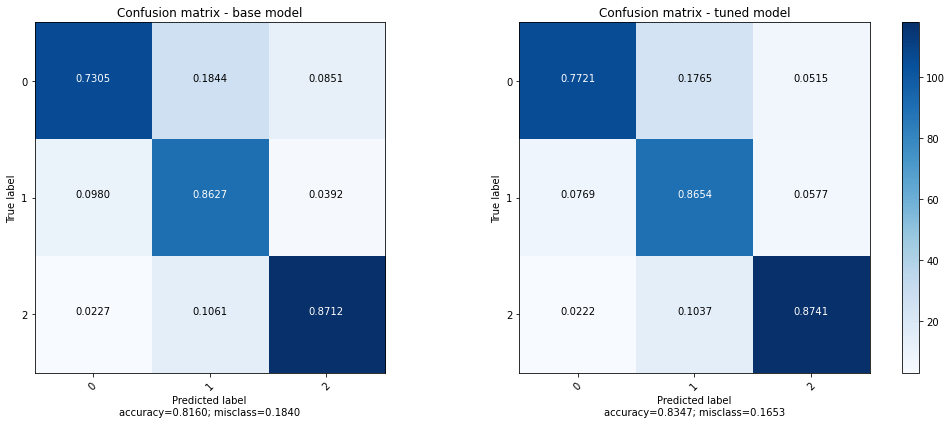

In [35]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
cm = confusion_matrix(cls_base.predict(X_test), y_test)
plot_cm_matrix(cm, np.unique(y_test),'Confusion matrix - base model')
plt.subplot(1,2,2)
cm = confusion_matrix(model.predict(X_test), y_test)
plot_cm_matrix(cm, np.unique(y_test),'Confusion matrix - tuned model')
plt.show()

### Multiple classification

In [45]:
data, label = make_multilabel_classification(n_samples=15000, n_features=50, n_classes=10, n_labels=1, random_state=0)

X, X_test, y, y_test = train_test_split(data, label, test_size=0.25, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(5625, 50) (5625, 50) (3750, 50) (5625, 10) (5625, 10) (3750, 10)


In [46]:
obj = {0:'multi:softprob', 1:'multi:softmax'}

fit_params = {'X': X_train,
              'y': y_train,
              'early_stopping_rounds': 5,
              'eval_metric': ['merror','mlogloss'],
              'eval_set': [(X_train, y_train), (X_val, y_val)],
              'verbose':False}

space = {'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
         'max_depth':  hp.choice('max_depth', np.arange(1, 15, dtype=int)),
         'min_child_weight': hp.choice('min_child_weight', np.arange(1, 15, dtype=int)),
         'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'objective': hp.choice('objective', list(obj.values())),
         'n_estimators': 1000,
         'num_class': num_classes,
         'use_label_encoder': False,
         'seed': 0}

In [47]:
def score_multiple_classification(params):
    reg = CustomMultiOutputClassifier(xgb.XGBClassifier(**params)).fit(**fit_params)
    f1 = [f1_score(reg.predict(X_test)[:,idx],y_test[:,idx]) for idx in range(y_test.shape[-1])]
    return {'loss': -np.sum(f1), 'status': STATUS_OK, 'model': reg}

def optimize_multiple_classification(trials, space, tries):
    return fmin(fn=score_multiple_classification, space=space, algo=tpe.suggest, max_evals=tries, trials=trials)

trials = Trials()
best = optimize_multiple_classification(trials, space, 250)
params = format_params(space, best)
model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

print('\n', params)

100%|████████████████████████████████████████████████| 50/50 [08:32<00:00, 10.25s/trial, best loss: -6.260328731340394]

 {'colsample_bytree': 0.8, 'eta': 0.125, 'gamma': 0.55, 'max_depth': 3, 'min_child_weight': 14, 'objective': 'multi:softmax', 'subsample': 0.55, 'n_estimators': 1000, 'num_class': 3, 'use_label_encoder': False, 'seed': 0}


In [53]:
cls_multi = CustomMultiOutputClassifier(xgb.XGBClassifier(num_class=2,
                                                          objective='multi:softmax',
                                                          use_label_encoder=False)).fit(**fit_params)

f1_base = [f1_score(cls_multi.predict(X_test)[:,idx],y_test[:,idx]) for idx in range(y_test.shape[-1])]
f1_tuned = [f1_score(model.predict(X_test)[:,idx],y_test[:,idx]) for idx in range(y_test.shape[-1])]

print(f'Base model mean F1-score: {np.mean(f1_base)}')
print(f'Tuned model mean F1-score: {np.mean(f1_tuned)}')

Base model mean F1-score: 0.5603529221360578
Tuned model mean F1-score: 0.6260328731340394


# Deep learning
###  CNN classifier

In [95]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

(X_train, y_train), (X_val, y_val) = fashion_mnist.load_data()
data, label = np.concatenate((X_train, X_val),axis=0), np.concatenate((y_train, y_val),axis=0)

X, X_test, y, y_test = train_test_split(data, label, test_size=0.1, stratify=label, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)

X_train, X_val, X_test = X_train.reshape(-1,28,28,1) / 255, X_val.reshape(-1,28,28,1) / 255, X_test.reshape(-1,28,28,1) / 255
y_train, y_val, y_test = to_categorical(y_train), to_categorical(y_val), to_categorical(y_test)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(31500, 28, 28, 1) (31500, 28, 28, 1) (7000, 28, 28, 1) (31500, 10) (31500, 10) (7000, 10)


In [106]:
def cnn_classification_model(params):
    
    model = Sequential()
    kernel_size = (params['kernel_size'], params['kernel_size'])
    model.add(Conv2D(32, kernel_size, input_shape=(28, 28, 1), activation=params['activation']))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout']))
    
    model.add(Conv2D(32, kernel_size, activation=params['activation']))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout']))

    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience_stop'])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=params['reduce_lr'], patience=params['patience_lr'])
    callbacks_list = [early_stop, reduce_lr]
    
    model.fit(X_train,
              y_train,
              epochs=15,
              batch_size = params['batch_size'],
              verbose = 0,
              callbacks=callbacks_list,
              validation_data = (X_val, y_val))
    score, acc = model.evaluate(X_test, y_test, verbose=0)
    
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

def optimize_dl_classification(trials, space, tries):
    return fmin(fn=cnn_classification_model, space=space, algo=tpe.suggest, max_evals=tries, trials=trials)

def format_params_cnn(space, best):
    for k in features.keys():
        best[k] = features[k].get(best[k])
    return best

In [107]:
features = {'activation':{0:'relu', 1:'elu'},
            'batch_size':{0:8, 1:16, 2:32},
            'kernel_size':{0:3, 1:5, 2:7},
            'patience_stop':{0:2, 1:3, 2:4},
            'reduce_lr':{0:2, 1:3, 2:4},
            'patience_lr':{0:2, 1:3, 2:4}}

space = {'batch_size': scope.int(hp.choice('batch_size', list(features['batch_size'].values()))),
         'dropout': hp.quniform('dropout',0.025, 0.5, 0.025),
         'kernel_size': scope.int(hp.choice('kernel_size', list(features['kernel_size'].values()))),
         'activation': hp.choice('activation', list(features['activation'].values())),
         'patience_stop':scope.int(hp.choice('patience_stop',list(features['patience_stop'].values()))),
         'reduce_lr':hp.quniform('reduce_lr',0.05, 0.25, 0.05),
         'patience_lr':scope.int(hp.choice('patience_lr',list(features['patience_lr'].values())))}

In [108]:
trials = Trials()
best = optimize_dl_classification(trials, space, 10)
params = format_params_cnn(space, best)
model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

print('\n', params)

100%|██████████████████████████████████████████████| 10/10 [50:49<00:00, 304.96s/trial, best loss: -0.9138571619987488]

 {'activation': 'relu', 'batch_size': 8, 'dropout': 0.30000000000000004, 'kernel_size': 5, 'patience_lr': 2, 'patience_stop': 4, 'reduce_lr': None}


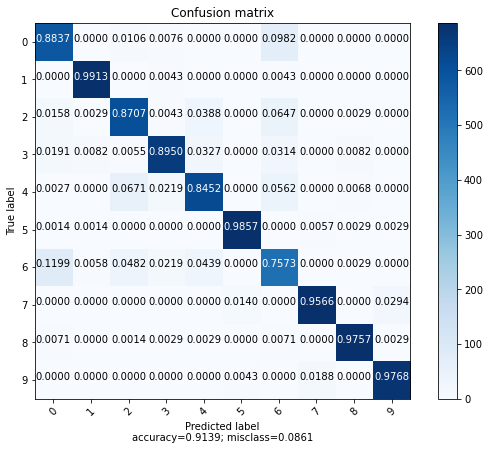

In [109]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(np.argmax(model.predict(X_test),axis=-1), np.argmax(y_test,axis=-1))
plot_cm_matrix(cm, np.arange(y_test.shape[-1]))